## Part 1: Importing Libraries

In [179]:
from src.modules import data_preprocessing as dp
from src.modules import data_visualization as dv
from src.modules import modeling as md

import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow import keras

## Part 2: Download Dataset

In [85]:
# Declare the ticker symbol. Here we use Tesla as an example.
symbol = "AAPL"

In [180]:
# Download the data from Yahoo Finance
df = dp.download_data(symbol)

[*********************100%%**********************]  1 of 1 completed


In [87]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-09-09,18.035713,18.139999,17.981428,18.077499,15.777155,340687200
2013-09-10,18.078571,18.123215,17.482143,17.665714,15.417769,743195600
2013-09-11,16.678928,16.917500,16.600357,16.703930,14.578370,898696400
2013-09-12,16.732143,16.978571,16.643213,16.881786,14.733595,404051200
2013-09-13,16.762142,16.851070,16.596430,16.603571,14.490782,298835600


## Part 3: EDA & Preprocessing

In [88]:
# Set global style
dv.set_global_style()

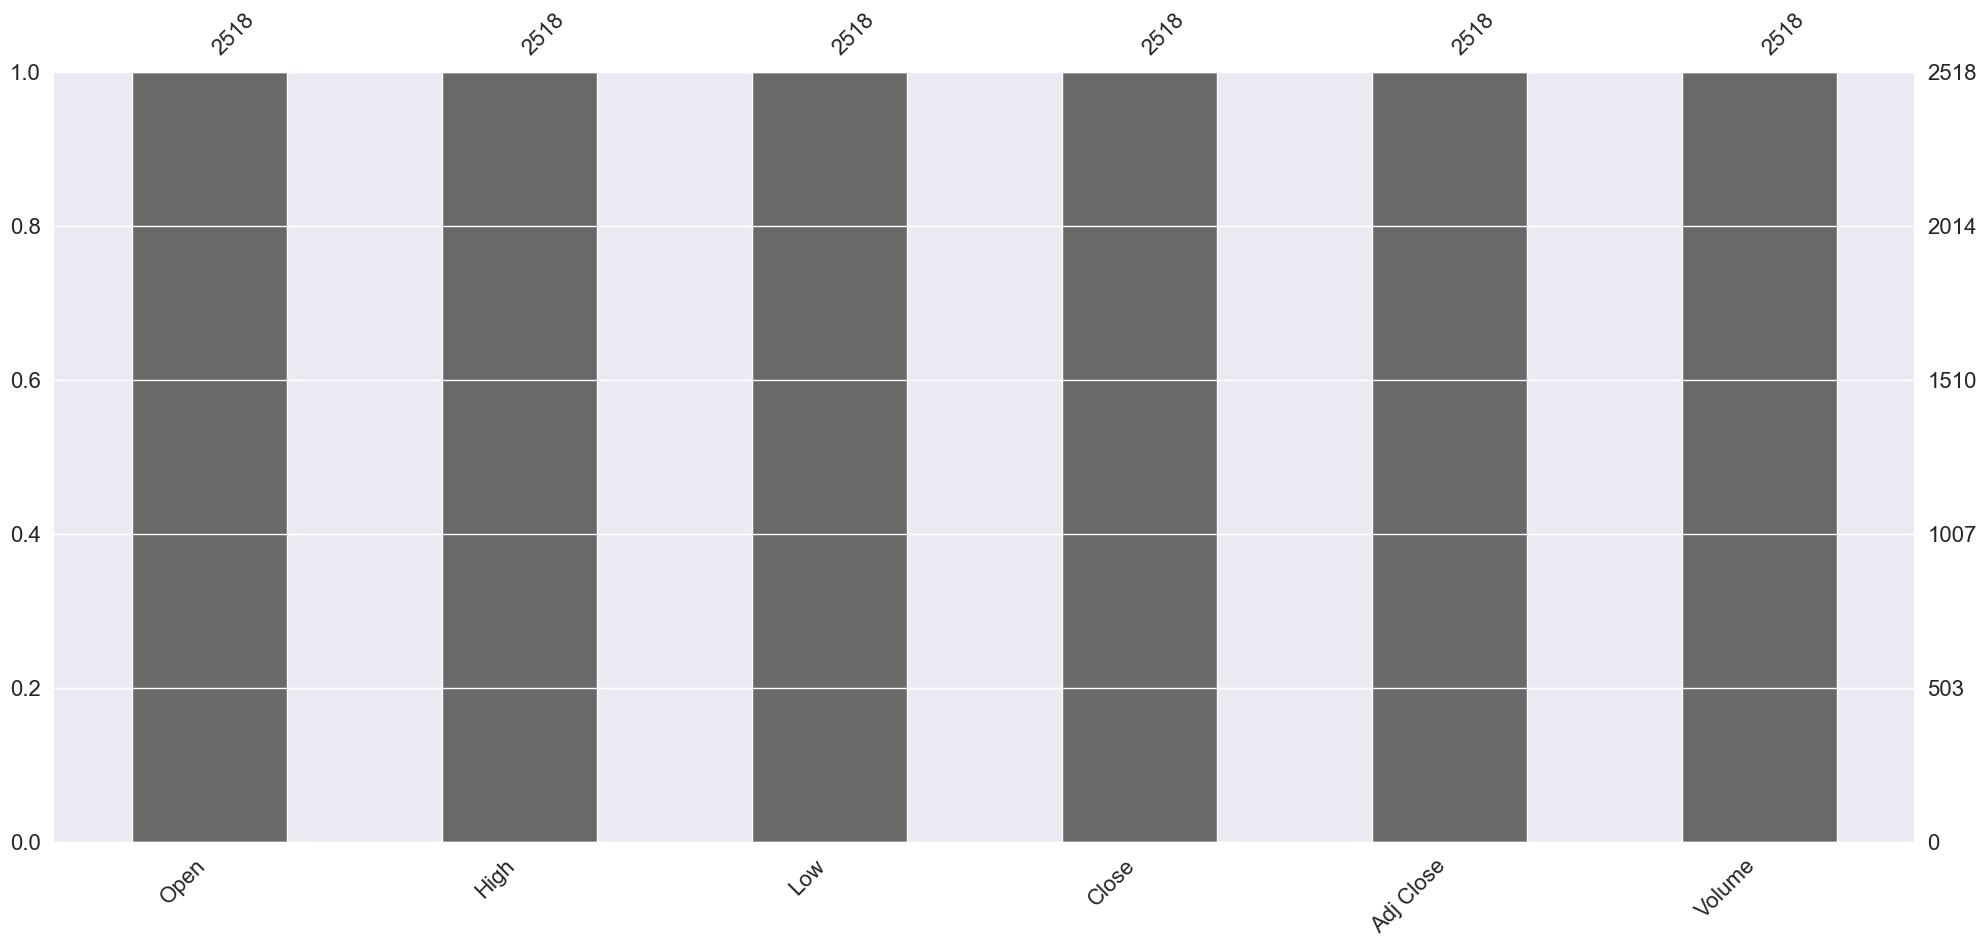

In [89]:
# Checking missing value
dv.plot_missing_values(df)

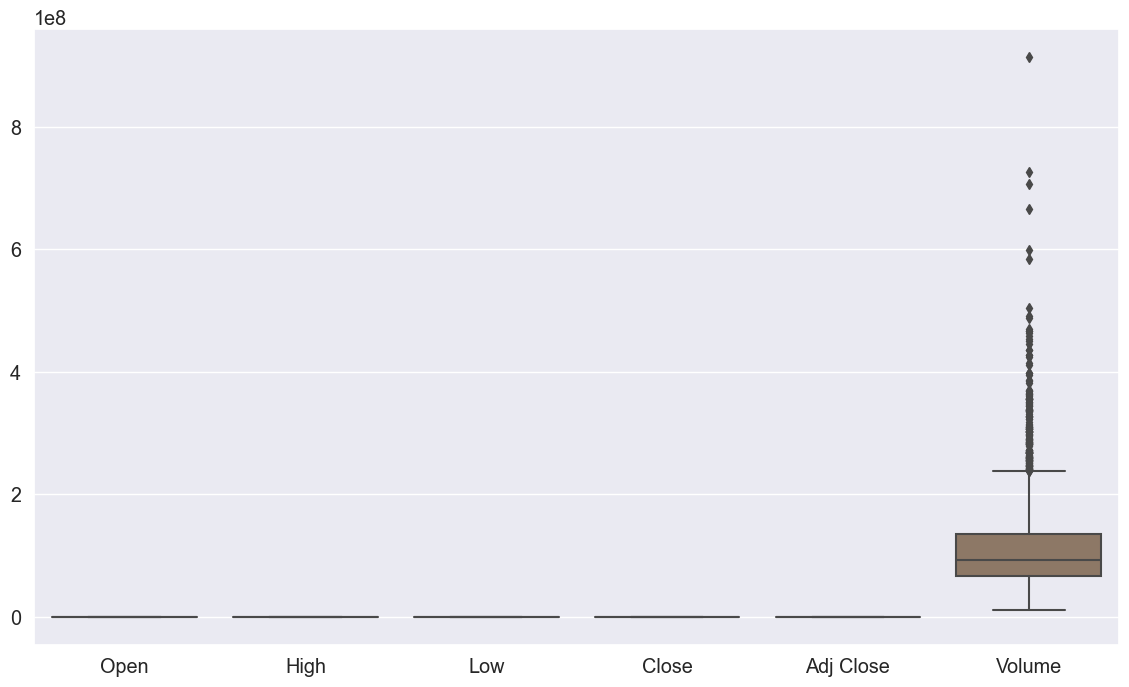

In [7]:
# Visualize the outliers data
dv.plot_outliers(df)

In [90]:
# Clean the data after checking the missing values and outliers
df = dp.clean_data(df)

In [91]:
# Change index to lowercase for convenience
df.index.name = df.index.name.lower()

In [92]:
df

,open,high,low,close,adj close,volume
date,,,,,,
2013-09-09,18.035713,18.139999,17.981428,18.077499,15.777155,340687200
2013-09-10,18.078571,18.123215,17.482143,17.665714,15.417769,743195600
2013-09-11,16.678928,16.917500,16.600357,16.703930,14.578370,898696400
2013-09-12,16.732143,16.978571,16.643213,16.881786,14.733595,404051200
2013-09-13,16.762142,16.851070,16.596430,16.603571,14.490782,298835600
...,...,...,...,...,...,...
2023-09-01,189.490005,189.919998,188.279999,189.460007,189.460007,45732600
2023-09-05,188.279999,189.979996,187.610001,189.699997,189.699997,45280000
2023-09-06,188.399994,188.850006,181.470001,182.910004,182.910004,81755800


In [93]:
df.shape

(2518, 6)

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2013-09-09 to 2023-09-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       2518 non-null   float64
 1   high       2518 non-null   float64
 2   low        2518 non-null   float64
 3   close      2518 non-null   float64
 4   adj close  2518 non-null   float64
 5   volume     2518 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.7 KB


In [95]:
df.describe()

,open,high,low,close,adj close,volume
count,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2.518000e+03
mean,72.729840,73.536154,71.968989,72.786049,70.875152,1.457540e+08
std,53.818113,54.467685,53.212923,53.867286,54.362402,9.342313e+07
min,15.998571,16.418215,15.972143,16.075714,14.030092,3.145820e+07
25%,28.828125,29.090625,28.503125,28.798125,26.269002,8.460510e+07
50%,45.865000,46.232500,45.293751,45.852499,43.972162,1.170898e+08
75%,127.820000,129.035004,126.187500,127.424997,125.772141,1.784946e+08
max,196.240005,198.229996,195.279999,196.449997,196.185074,1.065523e+09


Summary of EDA
- There are 2518 data points, 6 features
- 1All 6 features are numerical
- There are some outliers in `volume` feature, using data cleaning technique to set the value within an appropriate threshold
- There is no missing nor duplicated values

## Part 4: Data Transformation

In [ ]:
# get the adj close values
close_data = df.filter(['adj close'])
dataset = close_data.values

# select a subset of the data for training purpose
# the remaining set of the data is for validation
num_training_points = int(np.ceil(len(dataset) * .80))
print(num_training_points)

In [ ]:
# Scale the data to be values between 0 and 1 inclusive
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data_train = scaled_data[0:int(num_training_points), :]

print(scaled_data_train.shape)

## Part 5: Feature Engineering

In [ ]:
# Transform the data to supervised learning
window_size = 60 # window size is the number of previous days used to predict the next day. 

In [171]:
# Define feature and label data
features = [] # X_train
labels = [] # y_train
for i in range(window_size, len(scaled_data_train)):
    features.append(scaled_data_train[i-window_size:i, 0])
    labels.append(scaled_data_train[i, 0])

# Convert to numpy arrays
features = np.array(features)
labels = np.array(labels)


df_ft = pd.DataFrame(features)
# Reshape the data to be 3-dimensional in the form [number of samples, number of time steps, and number of features]
# We only want to predict 1 variable (adj close), so the last parameter is 1
# If we want to predict multiple variables, we can change the last parameter
features = np.reshape(features, (features.shape[0], features.shape[1], 1))

In [172]:
print(df_ft)

            0         1         2         3         4         5         6   \
0     0.009591  0.007618  0.003010  0.003862  0.002529  0.000000  0.000890   
1     0.007618  0.003010  0.003862  0.002529  0.000000  0.000890  0.002491   
2     0.003010  0.003862  0.002529  0.000000  0.000890  0.002491  0.003795   
3     0.003862  0.002529  0.000000  0.000890  0.002491  0.003795  0.002959   
4     0.002529  0.000000  0.000890  0.002491  0.003795  0.002959  0.006934   
...        ...       ...       ...       ...       ...       ...       ...   
1950  0.609772  0.611885  0.606358  0.613077  0.630039  0.625487  0.628250   
1951  0.611885  0.606358  0.613077  0.630039  0.625487  0.628250  0.637137   
1952  0.606358  0.613077  0.630039  0.625487  0.628250  0.637137  0.629930   
1953  0.613077  0.630039  0.625487  0.628250  0.637137  0.629930  0.639901   
1954  0.630039  0.625487  0.628250  0.637137  0.629930  0.639901  0.649005   

            7         8         9   ...        50        51    

## Part 6: Modeling

In [173]:
# Modeling
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units = 128, return_sequences = True, input_shape = (features.shape[1], 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units = 64, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units = 32, return_sequences = False),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.LSTM(units = 50),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 25),
    tf.keras.layers.Dense(units = 1)
])

In [174]:
# Check the model summary
print(model.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 60, 128)           66560     
                                                                 
 dropout_19 (Dropout)        (None, 60, 128)           0         
                                                                 
 lstm_43 (LSTM)              (None, 60, 64)            49408     
                                                                 
 dropout_20 (Dropout)        (None, 60, 64)            0         
                                                                 
 lstm_44 (LSTM)              (None, 32)                12416     
                                                                 
 dense_28 (Dense)            (None, 25)                825       
                                                                 
 dense_29 (Dense)            (None, 1)               

In [175]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [ ]:
# Train the model
history = model.fit(features, labels, epochs = 100, batch_size = 32, verbose = 1)

## Part 7: Evaluation Model

In [96]:
# Create the testing data set.
# The testing data set contains the remaining 20% of the data but we have to
# include the last 60 days from the training data set to predict the first stock price of the test data set
scaled_data_test = scaled_data[num_training_points - window_size:, :]

# Create the data sets x_test and y_test
x_test = []
y_test = dataset[num_training_points:, :]

for i in range(60, len(scaled_data_test)):
    x_test.append(scaled_data_test[i-window_size:i, 0])

# Convert the values into arrays for easier computation 
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
 
# predict the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
 
# evaluate result by mse and rmse metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

In [97]:
# Ploting the data
train = df[:num_training_points]
test = df[num_training_points:]
test['prediction'] = predictions
 
plt.figure(figsize=(10, 8))
plt.plot(train.index, train['adj close'])
plt.plot(test.index, test[['adj close', 'predictions']])
plt.title('Daily Stock Price of '+ symbol+ ' from ' + df.index[0] + ' to ' + df.index[-1])
plt.xlabel('date')
plt.ylabel("adj lose")
plt.legend(['Train', 'Test', 'Prediction'])

2015


In [160]:
# # Modeling
# model = tf.keras.models.Sequential([
#     tf.keras.layers.LSTM(units = 128, return_sequences = True, input_shape = (features.shape[1], 1)),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.LSTM(units = 64, return_sequences = True),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.LSTM(units = 32, return_sequences = True),
#     # tf.keras.layers.Dropout(0.2),
#     # tf.keras.layers.LSTM(units = 8, return_sequences = False),
#     # tf.keras.layers.Dropout(0.2),
#     # tf.keras.layers.LSTM(units = 50),
#     # tf.keras.layers.Dropout(0.2),
#     # tf.keras.layers.Dense(units = 50),
#     tf.keras.layers.Dense(units = 25),
#     tf.keras.layers.Dense(units = 1)
# ])

Future Predictions

In [138]:
# Function to generate the future forecasts
def future_forecasts(n_past, n_future, data, features, labels):

    x_past = features[- n_past - 1:, :, :][:1]  # last observed input sequence
    y_past = labels[- n_past - 1]             # last observed target value
    y_future = []                        # predicted target values

    for i in range(n_past + n_future):

        # feed the last forecast back to the model as an input
        x_past = np.append(x_past[:, 1:, :], y_past.reshape(1, 1, 1), axis=1)

        # generate the next forecast
        y_past = model.predict(x_past)

        # save the forecast
        y_future.append(y_past.flatten()[0])

    # transform the forecasts back to the original scale
    y_future = scaler.inverse_transform(np.array(y_future).reshape(-1, 1)).flatten()

    # add the forecasts to the data frame
    df_past = data.rename(columns={'adj close': 'Actual'}).copy()

    df_future = pd.DataFrame(
        index=pd.bdate_range(start=close_data.index[- n_past - 1] + pd.Timedelta(days=1), periods=n_past + n_future),
        columns=['Forecast'],
        data=y_future
    )

    return y_future, df_past.join(df_future, how='outer')

In [137]:
# prepare data for forecasting
forecast_data = df[['adj close']]

z = scaler.transform(forrecast_data)

# extract the input sequences and target values
window_size = 60

x, y = [], []

for i in range(window_size, len(z)):
    x.append(z[i - window_size: i])
    y.append(z[i])

x, y = np.array(x), np.array(y)

c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


<Axes: title={'center': 'AAPL'}>

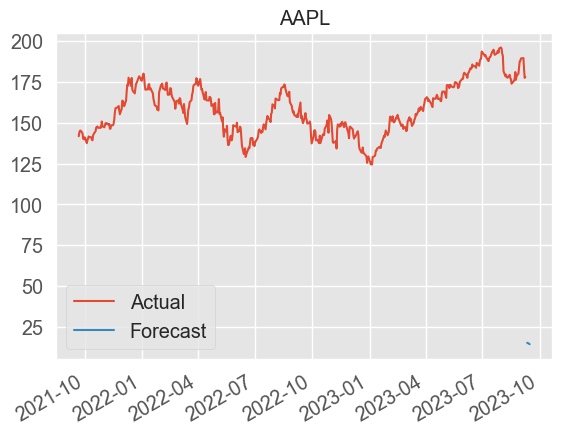

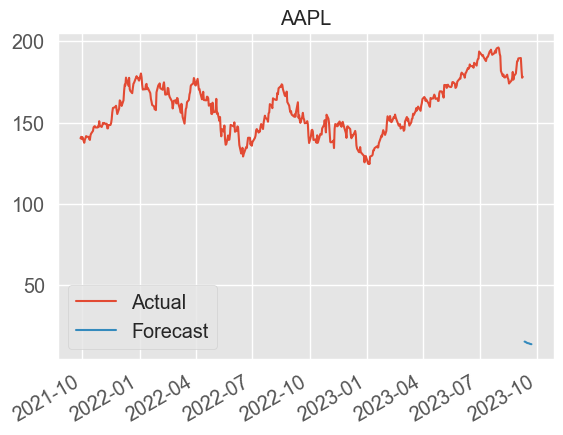

In [178]:
# forecast the next 5 days
y_future_5, df1 = multi_step_forecasts(n_past=0, n_future=5, data=df[['adj close']], features=x, labels=y)
df1.tail(500).plot(title=symbol)


# # forecast the next 10 days
y_future_10, df2 = multi_step_forecasts(n_past=0, n_future=10, data=df[['adj close']], features=x, labels=y)
df2.tail(500).plot(title=symbol)

In [157]:
print(y_future_5)

[178.48877 178.29913 177.87363 177.2483  176.53468]


In [158]:
print(y_future_10)

[178.48877 178.29913 177.87363 177.2483  176.53468 175.82805 175.18163
 174.61394 174.12335 173.70045 173.33498 173.01886 172.74611 172.51236
 172.31363 172.14615 172.00607 171.8894  171.79228 171.71106 171.64241
 171.5834  171.53142 171.48436 171.44048 171.39833 171.3568  171.31506
 171.27261 171.22902 171.18411 171.1379  171.09047 171.04208 170.99294
 170.94336 170.89368 170.84424 170.79535 170.7473  170.70038 170.65485
 170.61089 170.56871 170.52837 170.49    170.45364 170.41933 170.3871
 170.35692]


## Part 9: Flask App

## Part 10: Deployment

In [176]:
import pickle 
pickle.dump(model,open('model.pkl','wb'))

## Part 11: Conclusion